Visualisasi

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from implicit.nearest_neighbours import ItemItemRecommender
from implicit.evaluation import train_test_split, mean_average_precision_at_k

print("Semua library berhasil di-import.")
file_path_lokal = r'D:\Sem 7\Sistem Rekomendasi\proyek-sistem-informasi\data-books\train.csv'
file_path_lokal = file_path_lokal.strip().strip('"')

try:
    df = pd.read_csv(file_path_lokal)
    print(f"\nData '{file_path_lokal}' berhasil dimuat.")
    
    df['user_id_cat'] = df['user_id'].astype("category")
    df['item_id_cat'] = df['item_id'].astype("category")
    
    n_users = len(df['user_id_cat'].cat.categories)
    n_items = len(df['item_id_cat'].cat.categories)
    # Pastikan angka ini sesuai dengan error Anda:
    print(f"Users: {n_users}, Items: {n_items}") 

    # ===== INI ADALAH PERBAIKAN KRUSIAL =====
    # Pastikan (baris, kolom) adalah (user, item)
    interactions_matrix = sparse.csr_matrix(
        (np.ones(df.shape[0]),
         (df['user_id_cat'].cat.codes,  # <-- Baris = USER
          df['item_id_cat'].cat.codes) # <-- Kolom = ITEM
        ),
        shape=(n_users, n_items) # <-- Shape = (Users, Items)
    )
    # =======================================
    
    print(f"Shape Matriks: {interactions_matrix.shape}") # <-- HARUS (Users, Items)
    
    train_matrix, test_matrix = train_test_split(interactions_matrix, train_percentage=0.8, random_state=42)
    print(f"Shape Train Matrix: {train_matrix.shape}") # <-- HARUS (Users, Items)

    print("\nMulai melatih model baseline (IBCF)...")
    model_baseline = ItemItemRecommender(K=20)
    model_baseline.fit(train_matrix) # <-- Benar: (Users, Items)
    print("Model baseline (IBCF) selesai dilatih.")

    print("\nMulai menghitung skor MAP@10 untuk model baseline...")
    map10_baseline = mean_average_precision_at_k(model_baseline,
                                                 train_matrix, # <-- Benar: (Users, Items)
                                                 test_matrix,  # <-- Benar: (Users, Items)
                                                 K=10,
                                                 num_threads=0) 

    print("\n--- HASIL MODEL BASELINE (IBCF) ---")
    print(f"Skor MAP@10: {map10_baseline}")

except Exception as e:
    print(f"\nTerjadi error di Sel 1: {e}")

Semua library berhasil di-import.

Data 'D:\Sem 7\Sistem Rekomendasi\proyek-sistem-informasi\data-books\train.csv' berhasil dimuat.
Users: 13876, Items: 123069
Shape Matriks: (13876, 123069)
Shape Train Matrix: (13876, 123069)

Mulai melatih model baseline (IBCF)...


  0%|          | 0/123069 [00:00<?, ?it/s]

Model baseline (IBCF) selesai dilatih.

Mulai menghitung skor MAP@10 untuk model baseline...


  0%|          | 0/11454 [00:00<?, ?it/s]


--- HASIL MODEL BASELINE (IBCF) ---
Skor MAP@10: 0.018602178412511838


In [2]:
from implicit.als import AlternatingLeastSquares
import time
from threadpoolctl import threadpool_limits # Tambahkan import ini


print("Library untuk model ALS (AlternatingLeastSquares) berhasil di-import.")

# --- 1. Inisialisasi Model Canggih (ALS) ---

# Rekomendasi perbaikan untuk kode Anda (library implicit)
model_als = AlternatingLeastSquares(factors=256, 
                                  regularization=0.1, 
                                  iterations=25, 
                                  alpha=15.0, 
                                  random_state=42)
print("Model ALS berhasil diinisialisasi.")

# --- 2. Latih Model ALS ---

print("\nMulai melatih model canggih (ALS)...")
start_time = time.time()

# Mengatasi peringatan MKL (opsional tapi disarankan)
# Ini akan mematikan 'internal threadpool' MKL agar tidak bentrok
threadpool_limits(1, "blas")

# latih model HANYA pada data latih (train_matrix)

model_als.fit(train_matrix.T.tocsr()) 
end_time = time.time()
print(f"Model ALS selesai dilatih. Waktu: {end_time - start_time:.2f} detik")

# --- 3. Evaluasi Model ALS (MAP@10) ---
print("\nMulai menghitung skor MAP@10 untuk model ALS...")

# Hitung skor MAP@10
map10_als = mean_average_precision_at_k(model_als,

                                        train_matrix.T.tocsr(),

                                        test_matrix.T.tocsr(),

                                        K=10,

                                        num_threads=0) # Menggunakan semua core
print("\n--- HASIL MODEL CANGGIH (ALS) ---")
print(f"Skor MAP@10: {map10_als}")
print("\n--- PERBANDINGAN ---")

# Ambil 'map10_baseline' dari variabel yang sudah Anda jalankan di sel sebelumnya

print(f"Baseline (IBCF) MAP@10: {map10_baseline}") 
print(f"Advanced (ALS) MAP@10 : {map10_als}")

if map10_als > map10_baseline:

    print("\nSELAMAT! Model ALS Anda berhasil mengalahkan baseline. 👍")
else:

    print("\nModel ALS belum mengalahkan baseline. Coba 'tuning' parameter (factors, regularization, iterations).")

Library untuk model ALS (AlternatingLeastSquares) berhasil di-import.
Model ALS berhasil diinisialisasi.

Mulai melatih model canggih (ALS)...


C:\Anaconda3\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()


  0%|          | 0/25 [00:00<?, ?it/s]

Model ALS selesai dilatih. Waktu: 30.94 detik

Mulai menghitung skor MAP@10 untuk model ALS...


  0%|          | 0/36233 [00:00<?, ?it/s]


--- HASIL MODEL CANGGIH (ALS) ---
Skor MAP@10: 0.023412103077860163

--- PERBANDINGAN ---
Baseline (IBCF) MAP@10: 0.018602178412511838
Advanced (ALS) MAP@10 : 0.023412103077860163

SELAMAT! Model ALS Anda berhasil mengalahkan baseline. 👍



Membuat visualisasi perbandingan...


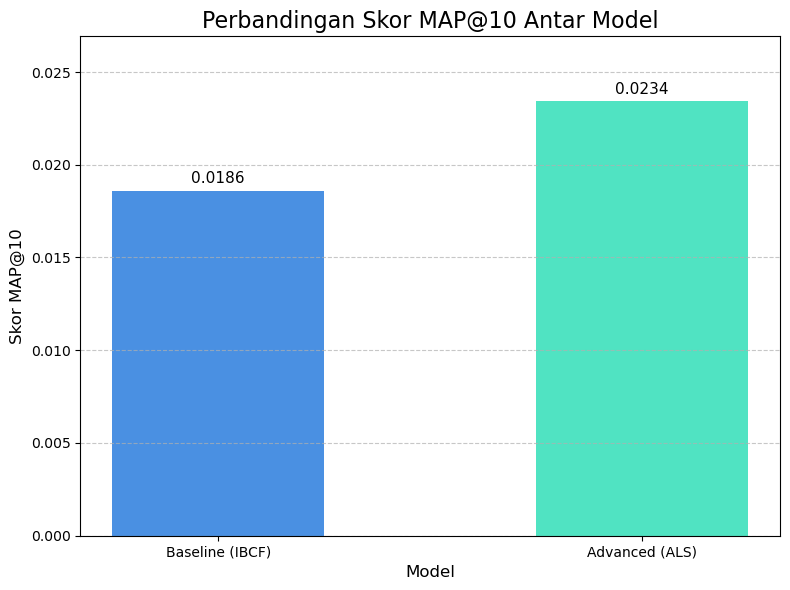

In [4]:
import matplotlib.pyplot as plt

# --- 4. Visualisasi Perbandingan ---
# Pastikan sel 1 (Baseline) dan 2 (ALS) sudah Anda jalankan.
# Kode ini akan mengambil variabel 'map10_baseline' dan 'map10_als'
# yang sudah ada di memori.

print("\nMembuat visualisasi perbandingan...")

# Data untuk plot
# Kita membandingkan dua model yang sudah Anda latih
model_names = ['Baseline (IBCF)', 'Advanced (ALS)']
scores = [map10_baseline, map10_als] 

# Membuat bar chart
plt.figure(figsize=(8, 6)) # Atur ukuran gambar
colors = ['#4A90E2', '#50E3C2'] # Warna bar (biru, toska)
bars = plt.bar(model_names, scores, color=colors, width=0.5) # Beri lebar agar tidak terlalu gemuk

# Menambahkan judul dan label
plt.title('Perbandingan Skor MAP@10 Antar Model', fontsize=16)
plt.ylabel('Skor MAP@10', fontsize=12)
plt.xlabel('Model', fontsize=12)

# Atur batas Y agar ada ruang di atas bar tertinggi
# Kita kalikan 1.15 (15% lebih tinggi)
plt.ylim(0, max(scores) * 1.15) 

# Menambahkan label nilai (skor) di atas setiap bar
# Ini adalah bagian penting agar angka mudah dibaca
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0,  # Posisi X (tengah bar)
             yval + (max(scores) * 0.01),        # Posisi Y (sedikit di atas bar)
             f'{yval:.4f}',                     # Teks (format 4 angka desimal)
             ha='center', va='bottom', fontsize=11)

# Tampilkan plot
plt.grid(axis='y', linestyle='--', alpha=0.7) # Tambahkan grid horizontal
plt.tight_layout() # Merapikan layout
plt.show()